In [1]:
import os
import pickle

import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

# Reading in and Preprocessing the Dataset

In [2]:
ROOT_DIR = r'C:\Users\rmdelgad\Documents\Berkeley MIDS\W266 Natural Language Processing\Final Project\Glassdoor'
PARSED_DATA_DIR = os.path.join(ROOT_DIR, 'parsed_data')
parsed_file = 'Glassdoor_English_2018-07-13.csv'

In [3]:
df = pd.read_csv(os.path.join(PARSED_DATA_DIR, parsed_file), sep='\t')
df['IsHelpful'] = df['Helpful'].gt(0).astype(int)
df['Review'] = (df['Pros'] + '. ' + df['Cons']).str.lower()
df = df.loc[~df['Review'].isnull(), ['Review', 'Company', 'IsHelpful']]

df.head()

,Review,Company,IsHelpful
0,"competitive salary, international opportunitie...",3M,0
1,not too many benefits are about it. isolation ...,3M,1
2,"benefits, fitness center, high tech environmen...",3M,0
3,"everyone treats you as their equal, and encour...",3M,0
4,"outstanding benefits, great advancement opport...",3M,0


# Dataset Exploration

Create a histogram of the word counts

In [5]:
vec = CountVectorizer()
wordcounts = vec.fit_transform(df['Review'])
words_per_review = np.squeeze(np.array(np.sum(wordcounts, axis=1)))

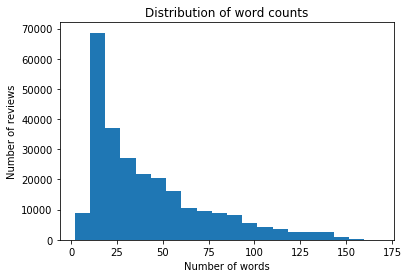

In [6]:
plt.hist(words_per_review, bins=20)
plt.title('Distribution of word counts')
plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.savefig('wordcounts.png')

Determine the vocabulary size

In [12]:
len(vec.vocabulary_)

110897

Create a Word Cloud

In [6]:
text = '\n\n'.join(df['Review'].tolist())
stopwords = set(STOPWORDS)

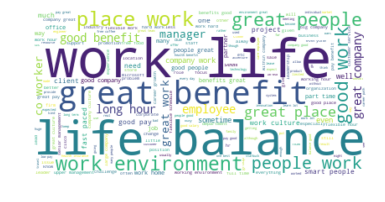

In [19]:
wc = WordCloud(max_words=200, stopwords=stopwords,
               random_state=1, background_color='white').generate(text)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('wordcloud.png')

In [8]:
avg_review_length = int(np.mean(words_per_review))
print(f'The average number of words in a review is: {avg_review_length}')

The average number of words in a review is: 41


Share of helpful/unhelpful reviews

In [9]:
valcounts = df['IsHelpful'].value_counts()
valcounts / valcounts.sum()

0    0.712367
1    0.287633
Name: IsHelpful, dtype: float64

In [14]:
df['ReviewLength'] = words_per_review
df.groupby('IsHelpful').agg({'ReviewLength': 'mean'})

,ReviewLength
IsHelpful,
0,35.365102
1,57.444173


In [15]:
df['ReviewLength'].max()

168

In [17]:
df.head()

,Review,Company,IsHelpful,ReviewLength
0,"competitive salary, international opportunitie...",3M,0,36
1,not too many benefits are about it. isolation ...,3M,1,22
2,"benefits, fitness center, high tech environmen...",3M,0,19
3,"everyone treats you as their equal, and encour...",3M,0,19
4,"outstanding benefits, great advancement opport...",3M,0,28


In [16]:
df['ReviewLength'].min()

2

In [11]:
df['Company'].value_counts().head(10)

Accenture       20800
Deloitte        20741
Starbucks       17797
Microsoft       17289
CiscoSystems    13105
Apple           11780
Google           7011
SAP              6390
KPMG             6337
CapitalOne       5637
Name: Company, dtype: int64

# Baseline Model Fitting

Fit an SVM w/ linear kernel and bigram word counts as features.

In [6]:
vec = CountVectorizer(ngram_range=(1,2))
X = vec.fit_transform(df['Review'])
y = df['IsHelpful'].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
clf = SGDClassifier()
param_grid = {'alpha': [0.001, 0.01, 0.1],
              'penalty': ['l2', 'l1', 'elasticnet'],
              'l1_ratio': [0.05, 0.15, 0.35, 0.5]}
grd = GridSearchCV(clf, param_grid, scoring='accuracy', 
                   n_jobs=4, cv=5, verbose=10)
grd.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   34.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   53.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  3.0min finished
C:\Users\rmdelg

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'alpha': [0.001, 0.01, 0.1], 'penalty': ['l2', 'l1', 'elasticnet'], 'l1_ratio': [0.05, 0.15, 0.35, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

In [17]:
grd.estimator

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [9]:
y_test_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)

In [18]:
acc

0.7398388091932747

In [21]:
# Save the model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(grd, f)